In [1]:
!pip install lottery-ticket-pruner
!pip install matplotlib

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import os
import shutil
import tensorflow as tf
from tensorflow import keras
from lottery_ticket_pruner import LotteryTicketPruner
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# The Speck cipher and data generation algorithms #
Taken from https://github.com/agohr/deep_speck/blob/master/speck.py

In [3]:
import numpy as np
from os import urandom

def WORD_SIZE():
    return(16);

def ALPHA():
    return(7);

def BETA():
    return(2);

MASK_VAL = 2 ** WORD_SIZE() - 1;

def shuffle_together(l):
    state = np.random.get_state();
    for x in l:
        np.random.set_state(state);
        np.random.shuffle(x);

def rol(x,k):
    return(((x << k) & MASK_VAL) | (x >> (WORD_SIZE() - k)));

def ror(x,k):
    return((x >> k) | ((x << (WORD_SIZE() - k)) & MASK_VAL));

def enc_one_round(p, k):
    c0, c1 = p[0], p[1];
    c0 = ror(c0, ALPHA());
    c0 = (c0 + c1) & MASK_VAL;
    c0 = c0 ^ k;
    c1 = rol(c1, BETA());
    c1 = c1 ^ c0;
    return(c0,c1);

def dec_one_round(c,k):
    c0, c1 = c[0], c[1];
    c1 = c1 ^ c0;
    c1 = ror(c1, BETA());
    c0 = c0 ^ k;
    c0 = (c0 - c1) & MASK_VAL;
    c0 = rol(c0, ALPHA());
    return(c0, c1);

def expand_key(k, t):
    ks = [0 for i in range(t)];
    ks[0] = k[len(k)-1];
    l = list(reversed(k[:len(k)-1]));
    for i in range(t-1):
        l[i%3], ks[i+1] = enc_one_round((l[i%3], ks[i]), i);
    return(ks);

def encrypt(p, ks):
    x, y = p[0], p[1];
    for k in ks:
        x,y = enc_one_round((x,y), k);
    return(x, y);

def decrypt(c, ks):
    x, y = c[0], c[1];
    for k in reversed(ks):
        x, y = dec_one_round((x,y), k);
    return(x,y);

def check_testvector():
  key = (0x1918,0x1110,0x0908,0x0100)
  pt = (0x6574, 0x694c)
  ks = expand_key(key, 22)
  ct = encrypt(pt, ks)
  if (ct == (0xa868, 0x42f2)):
    print("Testvector verified.")
    return(True);
  else:
    print("Testvector not verified.")
    return(False);

#convert_to_binary takes as input an array of ciphertext pairs
#where the first row of the array contains the lefthand side of the ciphertexts,
#the second row contains the righthand side of the ciphertexts,
#the third row contains the lefthand side of the second ciphertexts,
#and so on
#it returns an array of bit vectors containing the same data
def convert_to_binary(arr):
  X = np.zeros((4 * WORD_SIZE(),len(arr[0])),dtype=np.uint8);
  for i in range(4 * WORD_SIZE()):
    index = i // WORD_SIZE();
    offset = WORD_SIZE() - (i % WORD_SIZE()) - 1;
    X[i] = (arr[index] >> offset) & 1;
  X = X.transpose();
  return(X);

#takes a text file that contains encrypted block0, block1, true diff prob, real or random
#data samples are line separated, the above items whitespace-separated
#returns train data, ground truth, optimal ddt prediction
def readcsv(datei):
    data = np.genfromtxt(datei, delimiter=' ', converters={x: lambda s: int(s,16) for x in range(2)});
    X0 = [data[i][0] for i in range(len(data))];
    X1 = [data[i][1] for i in range(len(data))];
    Y = [data[i][3] for i in range(len(data))];
    Z = [data[i][2] for i in range(len(data))];
    ct0a = [X0[i] >> 16 for i in range(len(data))];
    ct1a = [X0[i] & MASK_VAL for i in range(len(data))];
    ct0b = [X1[i] >> 16 for i in range(len(data))];
    ct1b = [X1[i] & MASK_VAL for i in range(len(data))];
    ct0a = np.array(ct0a, dtype=np.uint16); ct1a = np.array(ct1a,dtype=np.uint16);
    ct0b = np.array(ct0b, dtype=np.uint16); ct1b = np.array(ct1b, dtype=np.uint16);
    
    #X = [[X0[i] >> 16, X0[i] & 0xffff, X1[i] >> 16, X1[i] & 0xffff] for i in range(len(data))];
    X = convert_to_binary([ct0a, ct1a, ct0b, ct1b]); 
    Y = np.array(Y, dtype=np.uint8); Z = np.array(Z);
    return(X,Y,Z);

#baseline training data generator
def make_train_data(n, nr, diff=(0x0040,0)):
  Y = np.frombuffer(urandom(n), dtype=np.uint8); Y = Y & 1;
  keys = np.frombuffer(urandom(8*n),dtype=np.uint16).reshape(4,-1);
  plain0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
  plain0r = np.frombuffer(urandom(2*n),dtype=np.uint16);
  plain1l = plain0l ^ diff[0]; plain1r = plain0r ^ diff[1];
  num_rand_samples = np.sum(Y==0);
  plain1l[Y==0] = np.frombuffer(urandom(2*num_rand_samples),dtype=np.uint16);
  plain1r[Y==0] = np.frombuffer(urandom(2*num_rand_samples),dtype=np.uint16);
  ks = expand_key(keys, nr);
  ctdata0l, ctdata0r = encrypt((plain0l, plain0r), ks);
  ctdata1l, ctdata1r = encrypt((plain1l, plain1r), ks);
  X = convert_to_binary([ctdata0l, ctdata0r, ctdata1l, ctdata1r]);
  return(X,Y);

#real differences data generator
def real_differences_data(n, nr, diff=(0x0040,0)):
  #generate labels
  Y = np.frombuffer(urandom(n), dtype=np.uint8); Y = Y & 1;
  #generate keys
  keys = np.frombuffer(urandom(8*n),dtype=np.uint16).reshape(4,-1);
  #generate plaintexts
  plain0l = np.frombuffer(urandom(2*n),dtype=np.uint16);
  plain0r = np.frombuffer(urandom(2*n),dtype=np.uint16);
  #apply input difference
  plain1l = plain0l ^ diff[0]; plain1r = plain0r ^ diff[1];
  num_rand_samples = np.sum(Y==0);
  #expand keys and encrypt
  ks = expand_key(keys, nr);
  ctdata0l, ctdata0r = encrypt((plain0l, plain0r), ks);
  ctdata1l, ctdata1r = encrypt((plain1l, plain1r), ks);
  #generate blinding values
  k0 = np.frombuffer(urandom(2*num_rand_samples),dtype=np.uint16);
  k1 = np.frombuffer(urandom(2*num_rand_samples),dtype=np.uint16);
  #apply blinding to the samples labelled as random
  ctdata0l[Y==0] = ctdata0l[Y==0] ^ k0; ctdata0r[Y==0] = ctdata0r[Y==0] ^ k1;
  ctdata1l[Y==0] = ctdata1l[Y==0] ^ k0; ctdata1r[Y==0] = ctdata1r[Y==0] ^ k1;
  #convert to input data for neural networks
  X = convert_to_binary([ctdata0l, ctdata0r, ctdata1l, ctdata1r]);
  return(X,Y);

# The depth-1/10 distinguisher implementation #
Taken from https://github.com/agohr/deep_speck/blob/master/train_nets.py and slightly adapted for running multiple trials. 

In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Dense, Conv1D, Input, Reshape, Permute, Add, Flatten, BatchNormalization, Activation, MaxPooling1D, Concatenate,Dropout, AveragePooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.regularizers import l2, l1, l1_l2


def cyclic_lr(num_epochs, high_lr, low_lr):
  res = lambda i: low_lr + ((num_epochs-1) - i % num_epochs)/(num_epochs-1) * (high_lr - low_lr);
  return(res);

#Batch size
bs = 5000;


def make_resnet(num_blocks=2, num_filters=32, num_outputs=1, d1=64, d2=64, word_size=16, ks=3,depth=5, reg_param=0.0001, final_activation='sigmoid'):
  
  #Input and preprocessing layers
  inp = Input(shape=(num_blocks * word_size * 2,));
  rs = Reshape((2 * num_blocks, word_size))(inp);
  perm = Permute((2,1))(rs);
    
  #Block 1
  conv0 = Conv1D(num_filters, kernel_size=1, padding='same', kernel_regularizer=l2(reg_param))(perm);
  conv0 = BatchNormalization()(conv0);
  conv0 = Activation('relu')(conv0);
    
  #Blocks 2-i - residual blocks
  shortcut = conv0;
  for i in range(depth):
    
    conv1 = Conv1D(num_filters, kernel_size=ks, padding='same', kernel_regularizer=l2(reg_param))(shortcut);
    conv1 = BatchNormalization()(conv1);
    conv1 = Activation('relu')(conv1);
    
    conv2 = Conv1D(num_filters, kernel_size=ks, padding='same',kernel_regularizer=l2(reg_param))(conv1);
    conv2 = BatchNormalization()(conv2);
    conv2 = Activation('relu')(conv2);
    shortcut = Add()([shortcut, conv2]);
    
  #Block 3
  flat1 = Flatten()(shortcut);
    
  dense1 = Dense(d1,kernel_regularizer=l2(reg_param))(flat1);
  dense1 = BatchNormalization()(dense1);
  dense1 = Activation('relu')(dense1);

  dense2 = Dense(d2, kernel_regularizer=l2(reg_param))(dense1);
  dense2 = BatchNormalization()(dense2);
  dense2 = Activation('relu')(dense2);
    
  out = Dense(num_outputs, activation=final_activation, kernel_regularizer=l2(reg_param))(dense2);

  model = Model(inputs=inp, outputs=out);

  return model



def model_builder(depth):

  model = make_resnet(depth=depth);
  model.compile(
          optimizer='adam',
          loss='binary_crossentropy',
          metrics=['acc']);
  return model;
  



def train_speck_distinguisher(model, num_epochs, num_rounds, X_train, Y_train, X_eval, Y_eval):
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience= 3, restore_best_weights= True);
    lr = LearningRateScheduler(cyclic_lr(10,0.002, 0.0001));
    
    history = model.fit(X_train, Y_train, batch_size= bs, epochs= num_epochs, validation_data= (X_eval, Y_eval), callbacks=[lr, stop_early,])
    best_epoch = np.argmax(history.history['val_acc']) + 1
    
    return(model,best_epoch);


For saving the model if needed

In [5]:
def save_model(model, name):
  model_save_name = name;
  #path = F"/content/gdrive/My Drive/{model_save_name}" 
  model.save(name)
  print("\n");

# Evaluate the results #
Taken from https://github.com/agohr/deep_speck/blob/master/eval.py and slightly adapted.

In [6]:
def evaluate(net,X,Y):
    
    Z = net.predict(X,batch_size=10000).flatten();
    Zbin = (Z > 0.5);
    
    #Compute the acc, tpr, tnr
    n = len(Z); 
    n0 = np.sum(Y==0); 
    n1 = np.sum(Y==1);
    
    acc = np.sum(Zbin == Y) / n;
    tpr = np.sum(Zbin[Y==1]) / n1;
    tnr = np.sum(Zbin[Y==0] == 0) / n0;
    
    return(acc, tpr, tnr); 

# Conduct multiple evaluations #


In [7]:
def multiple_evaluations(model, repetitions, num_rounds):
 
  #The accs, tprs, tnrs for all evaluation repetition
  accs = [];
  tprs = [];
  tnrs = [];
    
  #Evaluate multiple times and average the results 
  for i in range(0, repetitions):
    X_eval, Y_eval = make_train_data(10**6, num_rounds);

    (acc, tpr, tnr) = evaluate(model, X_eval, Y_eval);
    accs.append(acc);
    tprs.append(tpr);
    tnrs.append(tnr);

  print("Acc: " + str(np.mean(accs)) + str(" +- ") + str(np.std(accs)) + str("\t") + 
        "Tpr:" + str(np.mean(tprs)) + str(" +- ") + str(np.std(tprs)) + str("\t") +
        "Tnr:" + str(np.mean(tnrs)) + str(" +- ") + str(np.std(tnrs)) + str("\t"));
        
  return(np.mean(accs), np.mean(tprs), np.mean(tnrs));

# Create a plot with values for the baseline, pruned with one-shot, and pruned with iterative model #
The values can be Accuracy, TPR, or TNR

In [8]:
def create_figure(title, x_label, y_label, x0, y0,xy0err, x1, y1, xy1err, x2, y2, xy2err):
    
    fig, ax =  plt.subplots(figsize=(10,10));
    
    #trained baseline model 
    err= ax.errorbar(x0,y0,color = 'k', yerr=xy0err, ecolor='k', elinewidth=1, capsize=3);
    err[-1][0].set_linestyle('--'); 
    
    #one shot from initial
    err=ax.errorbar(x1,y1, color ='y',yerr=xy1err, ecolor="y", elinewidth=1, capsize=3);
    err[-1][0].set_linestyle('--');
    
    #iterative from initial
    err=ax.errorbar(x2,y2, color='g', yerr=xy2err, ecolor="g", elinewidth=1, capsize=3);
    err[-1][0].set_linestyle('--');
  
    plt.xlabel(x_label);
    plt.ylabel(y_label);

    plt.savefig(title +".png", bbox_inches='tight')

# Prune a model using the one-shot or iterative pruning method for multiple values of *p%* and train it #

In [9]:
def apply_pruning_method(pruning_method, num_repetition, depth, num_rounds, X_train, Y_train, X_eval, Y_eval, num_epochs, num_pruning_trials, initial_baseline_model, initial_baseline_model_weights, trained_baseline_model, trained_baseline_model_weights, prune_strategy, prune_percentage_for_iterative):

    #Instantiate the pruner
    pruner = LotteryTicketPruner(initial_baseline_model);

    #Store the accs, tprs, tnrs for each pruning trial (9 in total)
    pruned_accs =[];
    pruned_tprs = [];
    pruned_tnrs = [];
    
    pruning_trial_no=0;
    

    #Conduct numtiple pruning trials (9 in total, each for a different pruning percentage)
    for prune_percentage in list(np.linspace(start=0.1,stop=1,num=num_pruning_trials+1))[0:-1]:
        
        pruning_trial_no= pruning_trial_no+1;
        
        #Decide from what mask you want to start (new one for one-shot, previous one for iterative)
        if pruning_method=="one_shot":
          pruner.reset_masks();
        
        elif pruning_method=="iterative":
          prune_percentage = prune_percentage_for_iterative;
          
        #Set the initial weights and the ones after training    
        initial_baseline_model.set_weights(initial_baseline_model_weights);
        trained_baseline_model.set_weights(trained_baseline_model_weights);

        #Here the mask is obtained by removing prune_percentage of the trained_baseline_model's weights
        pruner.calc_prune_mask(trained_baseline_model, prune_percentage, prune_strategy);
        
        #Prune the initial_baseline_model of its weights using the above-computed mask (and starting from the same initial weights)
        pruner.apply_pruning(initial_baseline_model);

        
        #Train the above-pruned initial_baseline_model for at most the same number of epochs as the trained_baseline_model
        (pruned_trained_model, stoped_epoch) = train_speck_distinguisher(initial_baseline_model, num_epochs, num_rounds, X_train, Y_train, X_eval, Y_eval);

        print("Experiment repetition no:"+ str(num_repetition)+ " Pruned model at " + str(prune_percentage) + " pruning trial:"+ str(pruning_trial_no)+"\n");
        
        #Evaluate the pruned_trained_model
        (acc, tpr, tnr) = multiple_evaluations(pruned_trained_model,10,num_rounds);

        pruned_accs.append(acc);
        pruned_tprs.append(tpr);
        pruned_tnrs.append(tnr);

    #Return accs, tprs, tnrs for the (9) pruning trials
    return(pruned_accs, pruned_tprs, pruned_tnrs)

# Repeat:  Prune a model using the one-shot or iterative pruning method for multiple values of *p%*, train it, and evaluate the results #

In [10]:
def repeat_experiment(num_rounds=5, num_epochs=30, num_experiment_repetitions=5, num_pruning_trials= 9, depth=10, data_for_experiment="Real_vs_Random", prune_strategy="smallest_weights_global", prune_percentage_for_iterative=0.2):
    
    
    #Accs, tprs, tnrs for all (5) repetitions and (9) pruning trials for the baseline, pruned with one-shot and pruned with iterative models
    baseline_accuracies_all_trials=[];
    baseline_tprs_all_trials=[];
    baseline_tnrs_all_trials=[];

    pruned_accuracies_all_trials_one_shot_from_initial=[[] for x in range(num_pruning_trials)];
    pruned_tprs_all_trials_one_shot_from_initial=[[] for x in range(num_pruning_trials)];
    pruned_tnrs_all_trials_one_shot_from_initial=[[] for x in range(num_pruning_trials)];

    pruned_accuracies_all_trials_iterative_from_initial=[[] for x in range(num_pruning_trials)];
    pruned_tprs_all_trials_iterative_from_initial=[[] for x in range(num_pruning_trials)];
    pruned_tnrs_all_trials_iterative_from_initial=[[] for x in range(num_pruning_trials)];

   
    #Repeat the experiment multiple times (5)
    for repetition in range(0,num_experiment_repetitions):

        #Compute the dataset (the real-vs-random experiment was chosen; however, the real-differences experiment can be run as well)
        if data_for_experiment=="Real_vs_Random":      
            X_train, Y_train = make_train_data(10**7,num_rounds);
            X_eval, Y_eval = make_train_data(10**6, num_rounds);
        elif data_for_experiment=="Real_differences":
            X_train, Y_train = real_differences_data(10**7,num_rounds);
            X_eval, Y_eval = real_differences_data(10**6, num_rounds);

        #Build the initial_baseline_model and save its weights   
        initial_baseline_model = model_builder(depth);
        initial_baseline_model_weights = initial_baseline_model.get_weights();

        #Train the initial_baseline_model and save the trained model's weights   
        (trained_baseline_model,trnd_bm_stop_epoch) = train_speck_distinguisher(initial_baseline_model, num_epochs, num_rounds, X_train, Y_train, X_eval, Y_eval);
        trained_baseline_model_weights = trained_baseline_model.get_weights();
       
        #Evaluate the trained_baseline_model 
        print("Baseline model results at repetition "+str(repetition)+":\n");
        (b_acc, b_tpr, b_tnr) =multiple_evaluations(trained_baseline_model,10,num_rounds);
        
        #Save the trained_baseline_model's acc, tpr, tnr
        baseline_accuracies_all_trials.append(b_acc);
        baseline_tprs_all_trials.append(b_tpr);
        baseline_tnrs_all_trials.append(b_tnr);

        #Conduct one-shot pruning one time, for multiple pruning percentages (9 trials) 
        print("Starting One-Shot with initialization from original initial network:\n");
        (oneShot_from_initial_pruned_accs, oneShot_from_initial_pruned_tprs, oneShot_from_initial_pruned_tnrs)=apply_pruning_method("one_shot", repetition, depth, num_rounds, X_train, Y_train, X_eval, Y_eval, trnd_bm_stop_epoch, num_pruning_trials, initial_baseline_model, initial_baseline_model_weights, trained_baseline_model, trained_baseline_model_weights, prune_strategy, prune_percentage_for_iterative);
        
        #Conduct iterative pruning one time, for multiple pruning percentages (9 trials) 
        print("Starting Iterative with initialization from original initial network:\n");
        (iterative_from_initial_pruned_accs, iterative_from_initial_pruned_tprs, iterative_from_initial_pruned_tnrs)=apply_pruning_method("iterative", repetition, depth, num_rounds, X_train, Y_train, X_eval, Y_eval, trnd_bm_stop_epoch, num_pruning_trials, initial_baseline_model, initial_baseline_model_weights, trained_baseline_model, trained_baseline_model_weights, prune_strategy, prune_percentage_for_iterative);
  
        #Save the accs, tprs, tnrs from the above 2*9 pruning trials
        for i in range(0,num_pruning_trials):
            pruned_accuracies_all_trials_one_shot_from_initial[i].append(oneShot_from_initial_pruned_accs[i]);
            pruned_tprs_all_trials_one_shot_from_initial[i].append(oneShot_from_initial_pruned_tprs[i]);
            pruned_tnrs_all_trials_one_shot_from_initial[i].append(oneShot_from_initial_pruned_tnrs[i]);

            pruned_accuracies_all_trials_iterative_from_initial[i].append(iterative_from_initial_pruned_accs[i]);
            pruned_tprs_all_trials_iterative_from_initial[i].append(iterative_from_initial_pruned_tprs[i]);
            pruned_tnrs_all_trials_iterative_from_initial[i].append(iterative_from_initial_pruned_tnrs[i]);

            
    #Return the accs, tprs, tnrs for the baseline, pruned with one-shot, pruned with iterative models.    
    return (    baseline_accuracies_all_trials, baseline_tprs_all_trials, baseline_tnrs_all_trials,
                pruned_accuracies_all_trials_one_shot_from_initial, pruned_tprs_all_trials_one_shot_from_initial, pruned_tnrs_all_trials_one_shot_from_initial, 
                pruned_accuracies_all_trials_iterative_from_initial, pruned_tprs_all_trials_iterative_from_initial, pruned_tnrs_all_trials_iterative_from_initial,
           );
            

Compute pruning percentage (*p%*) values for iterative pruning

In [11]:
def compute_pruning_percentages_iterative(num_pruning_trials, pruning_percentage):
  
  remaining_weights=1;
  percentages=[];

  for i in range(0, num_pruning_trials):
    remaining_weights= remaining_weights - remaining_weights*pruning_percentage;
    percentages.append(1- remaining_weights);

  return percentages;

# Create the Accuracy, TPR and TNR plots #

In [12]:
def create_plots_for_executed_experiments(experiment_type, depth, num_rounds, num_experiment_repetitions, num_pruning_trials, prune_percentage_for_iterative, b_accs, b_tprs, b_tnrs, os_init_accs, os_init_tprs, os_init_tnrs, it_init_accs, it_init_tprs, it_init_tnrs):
        
      #Details about the experiment  
      print("Experiment type: "+experiment_type);
      print("Model depth: "+ str(depth));
      print("Speck reduced to "+str(num_rounds) +" R");

      #Compute pruning percentages for both experiments (9 pruning percentages)  
      pruning_percentages_one_shot = list(np.linspace(start=0.1,stop=1,num=num_pruning_trials+1))[0:-1];
      pruning_percentages_iterative = compute_pruning_percentages_iterative(num_pruning_trials, prune_percentage_for_iterative);

      #Store the accs, tprs, tnrs per experiment repetition
      b_accs0 =[];
      b_accs0err=[[],[]];
      b_tprs0 =[];
      b_tprs0err = [[],[]];
      b_tnrs0 = [];
      b_tnrs0err = [[],[]]; 
        
    
      os_init_accs1= [];
      os_init_accs1err= [[],[]];

      os_init_tprs1= [];
      os_init_tprs1err= [[],[]];

      os_init_tnrs1= [];
      os_init_tnrs1err= [[],[]];
      

      it_init_accs3= [];
      it_init_accs3err= [[],[]];

      it_init_tprs3= [];
      it_init_tprs3err= [[],[]];

      it_init_tnrs3= [];
      it_init_tnrs3err= [[],[]];
      
      #Put the accs, tprs, tnrs and error bars in the corresponding lists for making the plots for the baseline model  
      b_accs0 = [np.mean(b_accs)] *  num_pruning_trials;
      b_accs0err[0] = [np.mean(b_accs)-np.min(b_accs)] * num_pruning_trials;
      b_accs0err[1] = [np.max(b_accs) -np.mean(b_accs)] * num_pruning_trials;

      b_tprs0 = [np.mean(b_tprs)] * num_pruning_trials;
      b_tprs0err[0] = [np.mean(b_tprs)-np.min(b_tprs)]* num_pruning_trials;
      b_tprs0err[1] = [np.max(b_tprs) -np.mean(b_tprs)]* num_pruning_trials;

      b_tnrs0 = [np.mean(b_tnrs)] * num_pruning_trials;
      b_tnrs0err[0] = [np.mean(b_tnrs)-np.min(b_tnrs)] * num_pruning_trials;
      b_tnrs0err[1] = [np.max(b_tnrs)-np.mean(b_tnrs)] * num_pruning_trials;



      #Put the accs, tprs, tnrs and error bars in the corresponding lists for making the plots for the pruned with one-shot and iterative model
      for repetition in range(0, num_pruning_trials):
        
          os_init_accs1.append(np.mean(os_init_accs[repetition]));
          os_init_accs1err[0].append(np.mean(os_init_accs[repetition])- np.min(os_init_accs[repetition]));
          os_init_accs1err[1].append(np.max(os_init_accs[repetition]) - np.mean(os_init_accs[repetition]));

          os_init_tprs1.append(np.mean(os_init_tprs[repetition]));
          os_init_tprs1err[0].append(np.mean(os_init_tprs[repetition]) - np.min(os_init_tprs[repetition]));
          os_init_tprs1err[1].append(np.max(os_init_tprs[repetition]) - np.mean(os_init_tprs[repetition]));

          os_init_tnrs1.append(np.mean(os_init_tnrs[repetition]));
          os_init_tnrs1err[0].append(np.mean(os_init_tnrs[repetition])- np.min(os_init_tnrs[repetition]));
          os_init_tnrs1err[1].append(np.max(os_init_tnrs[repetition]) -np.mean(os_init_tnrs[repetition]));
        

          it_init_accs3.append(np.mean(it_init_accs[repetition]));
          it_init_accs3err[0].append(np.mean(it_init_accs[repetition]) - np.min(it_init_accs[repetition]));
          it_init_accs3err[1].append(np.max(it_init_accs[repetition]) - np.mean(it_init_accs[repetition]));

          it_init_tprs3.append(np.mean(it_init_tprs[repetition]));
          it_init_tprs3err[0].append(np.mean(it_init_tprs[repetition])-np.min(it_init_tprs[repetition]));
          it_init_tprs3err[1].append(np.max(it_init_tprs[repetition]) - np.mean(it_init_tprs[repetition]));

          it_init_tnrs3.append(np.mean(it_init_tnrs[repetition]));
          it_init_tnrs3err[0].append(np.mean(it_init_tnrs[repetition])-np.min(it_init_tnrs[repetition]));
          it_init_tnrs3err[1].append(np.max(it_init_tnrs[repetition]) - np.mean(it_init_tnrs[repetition]));


   
      #Create the acc, tpr, tnr figures for the baseline, pruned with one-shot and iterative models
      create_figure("Accuracies-"+"R:"+str(num_rounds)+"-"+experiment_type,"Pruned ratio", "Accuracy", pruning_percentages_one_shot, b_accs0, b_accs0err, pruning_percentages_one_shot, os_init_accs1, os_init_accs1err, pruning_percentages_iterative, it_init_accs3, it_init_accs3err);
      create_figure("TPRS-"+"R:"+str(num_rounds)+"-"+experiment_type,"Pruned ratio", "TPR", pruning_percentages_one_shot, b_tprs0, b_tprs0err, pruning_percentages_one_shot, os_init_tprs1, os_init_tprs1err, pruning_percentages_iterative, it_init_tprs3, it_init_tprs3err);
      create_figure("TNRS-"+"R:"+str(num_rounds) +"-"+experiment_type,"Pruned ratio", "TNR", pruning_percentages_one_shot, b_tnrs0, b_tnrs0err, pruning_percentages_one_shot, os_init_tnrs1, os_init_tnrs1err, pruning_percentages_iterative, it_init_tnrs3, it_init_tnrs3err);
    





# Run the experiment #

In [13]:
num_rounds=7; # 5, 6, 7, 8
num_epochs=20;
num_experiment_repetitions=3; # 5
num_pruning_trials= 9;
depth=1; # 1, 10
data_for_experiment="Real_vs_Random";
experiment_type= data_for_experiment;
prune_strategy="smallest_weights_global";
prune_percentage_for_iterative=0.2;
     

In [14]:
(   b_accs, b_tprs, b_tnrs,
    os_init_accs, os_init_tprs, os_init_tnrs,
    it_init_accs, it_init_tprs, it_init_tnrs) = repeat_experiment(num_rounds, num_epochs, num_experiment_repetitions, num_pruning_trials, depth,data_for_experiment,prune_strategy, prune_percentage_for_iterative);
     

Epoch 1/20
2000/2000 [==============================] - 46s 10ms/step - loss: 0.7074 - acc: 0.5110 - val_loss: 0.6787 - val_acc: 0.5815
Epoch 2/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6720 - acc: 0.5925 - val_loss: 0.6700 - val_acc: 0.5953
Epoch 3/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6681 - acc: 0.5967 - val_loss: 0.6675 - val_acc: 0.5969
Epoch 4/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6666 - acc: 0.5978 - val_loss: 0.6665 - val_acc: 0.5973
Epoch 5/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6654 - acc: 0.5993 - val_loss: 0.6652 - val_acc: 0.5993
Epoch 6/20
2000/2000 [==============================] - 20s 10ms/step - loss: 0.6640 - acc: 0.6011 - val_loss: 0.6641 - val_acc: 0.6017
Epoch 7/20
2000/2000 [==============================] - 21s 10ms/step - loss: 0.6623 - acc: 0.6037 - val_loss: 0.6623 - val_acc: 0.6036
Epoch 8/20
2000/2000 [==========================

# Create the plots #

Experiment type: Real_vs_Random
Model depth: 1
Speck reduced to 7 R


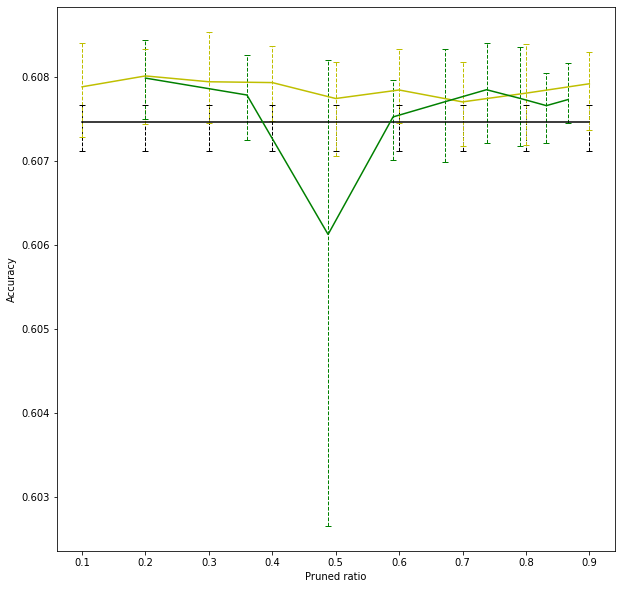

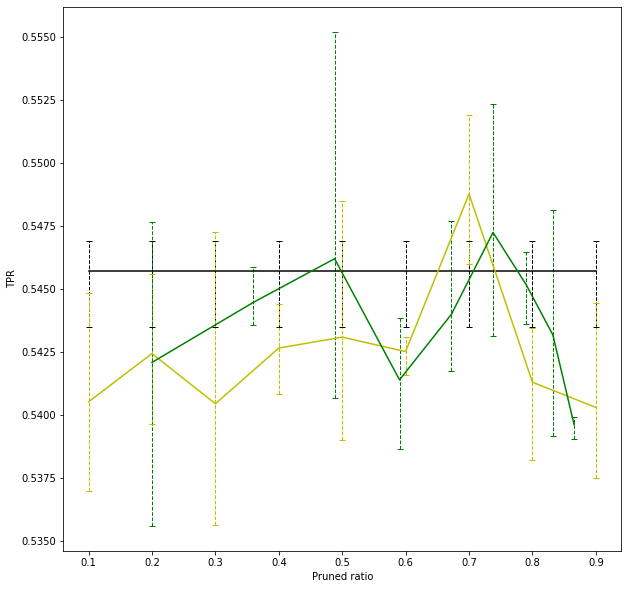

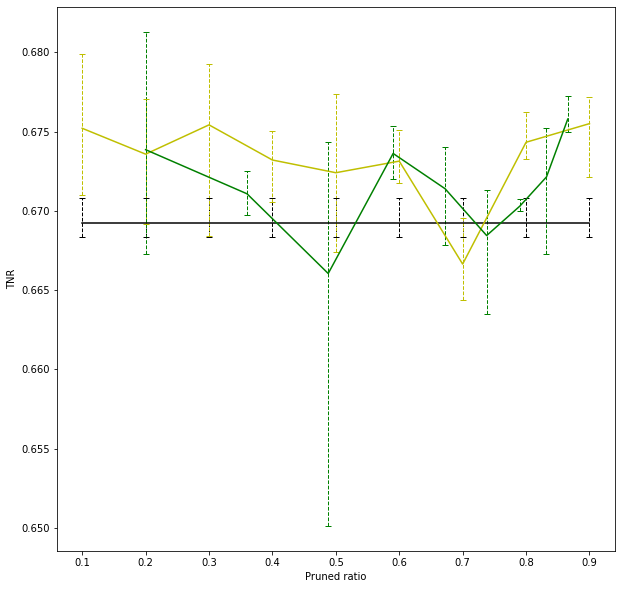

In [15]:
create_plots_for_executed_experiments(experiment_type, depth, num_rounds, num_experiment_repetitions, num_pruning_trials, prune_percentage_for_iterative, b_accs, b_tprs, b_tnrs, os_init_accs, os_init_tprs, os_init_tnrs, it_init_accs, it_init_tprs, it_init_tnrs)
